<a href="https://colab.research.google.com/github/Peace3B/Plant_Disease_Detection_System/blob/main/Plant_Disease_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Plant Disease Detection - Complete ML Pipeline
# Notebook for training, evaluation, and analysis

# 1. SETUP AND IMPORTS

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Metrics and Evaluation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc
from sklearn.preprocessing import label_binarize
import pickle

# Set random seeds
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.19.0
GPU Available: []


In [16]:
# Cell 2: Configuration
from pathlib import Path
class Config:
    # Paths
    BASE_DIR = Path(".")
    # Update DATA_DIR to point to your Google Drive path
    # Replaced 'Your_Dataset_Folder_Name' with the actual name 'PlantVillage'
    DATA_DIR = Path("/content/drive/MyDrive/PlantVillage")
    TRAIN_DIR = DATA_DIR / "train"
    TEST_DIR = DATA_DIR / "test"
    MODEL_DIR = BASE_DIR / "models"

    # Model parameters
    IMAGE_SIZE = (224, 224)
    BATCH_SIZE = 32
    EPOCHS = 20
    LEARNING_RATE = 0.001

    # Classes - Update based on your dataset
    CLASSES = ['Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight',
               'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_healthy', 'Pepper_bell_Bacateria', 'Pepper_bell_healthy', 'Potato_Early_blight']

    NUM_CLASSES = len(CLASSES)

config = Config()

# Create directories
config.MODEL_DIR.mkdir(parents=True, exist_ok=True)
# Note: DATA_DIR will now be created on your Google Drive if it doesn't exist,
# but you should ensure the 'train' and 'test' subdirectories exist within it.
config.DATA_DIR.mkdir(parents=True, exist_ok=True)

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
import os

# List contents of MyDrive
print("Contents of /content/drive/MyDrive/")
print("-----------------------------------")
try:
    for item in os.listdir('/content/drive/MyDrive/'):
        print(item)
except FileNotFoundError:
    print("Google Drive not mounted or path not found. Please ensure Google Drive is mounted correctly.")

print("\n-----------------------------------")
print("Looking for 'PlantVillage' folder. If it's there, check its contents:")
plant_village_path = '/content/drive/MyDrive/PlantVillage'
if os.path.exists(plant_village_path):
    print(f"Contents of {plant_village_path}/")
    print("-----------------------------------")
    for item in os.listdir(plant_village_path):
        print(item)
else:
    print(f"The folder '{plant_village_path}' does not exist in your Google Drive. Please ensure the name is correct.")


Contents of /content/drive/MyDrive/
-----------------------------------
Colab Notebooks
PlantVillage
PXL_20230503_083842405.PORTRAIT.jpg
Copy of 2020_SP_ALU Resume Template [MAKE A COPY].gdoc
SDL
Mission Activity..gdoc
Untitled document (18).gdoc
Untitled presentation (1).gslides
MY ISLAND.gdoc
SDL_Assessment 1- Google slides..gslides
Pre-Discovery session assignment..gdoc
HCD IN AFRICA..gdoc
GRAND CHALLENGES AND GRAND OPPORTUNITIES.gdoc
Untitled document (17).gdoc
Copy of Reflective Thinking  Formative Assessment Toolkit (1).gslides
Sentence Combining Worksheet.gdoc
Copy of Reflective Thinking  Formative Assessment Toolkit.gslides
Peace Keza_Reflective Thinking  Formative Assessment Toolkit.gslides
MISSION STATEMENT NEGPOD..gdoc
SDL assessment toolkit_2.gslides
Introducing myself as a writer..gdoc
Prototype.gdoc
Untitled document (16).gdoc
PEACE_KEZA_FreeWriting_T1_Session3 (3).gdoc
PEACE_KEZA_FreeWriting_T1_Session3 (2).gdoc
 How does alcohol influence giving receiving consent?.gdoc


In [19]:
import pandas as pd
import os # os is also used, ensure it is available if not already

filepaths = []
labels = []

for root, dirs, files in os.walk(config.DATA_DIR):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            filepath = os.path.join(root, file)
            label = os.path.basename(root) # The class label is the directory name
            filepaths.append(filepath)
            labels.append(label)

df = pd.DataFrame({
    'filepath': filepaths,
    'label': labels
})

print(f"Total images found: {len(df)}")
print("DataFrame head:")
print(df.head())

Total images found: 20669
DataFrame head:
                                            filepath  \
0  /content/drive/MyDrive/PlantVillage/Tomato__To...   
1  /content/drive/MyDrive/PlantVillage/Tomato__To...   
2  /content/drive/MyDrive/PlantVillage/Tomato__To...   
3  /content/drive/MyDrive/PlantVillage/Tomato__To...   
4  /content/drive/MyDrive/PlantVillage/Tomato__To...   

                                   label  
0  Tomato__Tomato_YellowLeaf__Curl_Virus  
1  Tomato__Tomato_YellowLeaf__Curl_Virus  
2  Tomato__Tomato_YellowLeaf__Curl_Virus  
3  Tomato__Tomato_YellowLeaf__Curl_Virus  
4  Tomato__Tomato_YellowLeaf__Curl_Virus  


In [20]:
from sklearn.model_selection import train_test_split

# Perform a stratified train-test split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

print(f"Shape of training DataFrame: {train_df.shape}")
print(f"Shape of testing DataFrame: {test_df.shape}")

Shape of training DataFrame: (16535, 2)
Shape of testing DataFrame: (4134, 2)


In [21]:
unique_classes = sorted(train_df['label'].unique().tolist())
config.CLASSES = unique_classes
config.NUM_CLASSES = len(unique_classes)

print(f"Updated Config.CLASSES: {config.CLASSES}")
print(f"Updated Config.NUM_CLASSES: {config.NUM_CLASSES}")

Updated Config.CLASSES: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']
Updated Config.NUM_CLASSES: 15


In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='label',
    target_size=config.IMAGE_SIZE,
    batch_size=config.BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    classes=config.CLASSES,
    seed=42
)

validation_generator = val_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepath',
    y_col='label',
    target_size=config.IMAGE_SIZE,
    batch_size=config.BATCH_SIZE,
    class_mode='categorical',
    classes=config.CLASSES,
    seed=42
)

print("Data generators initialized.")

Found 16535 validated image filenames belonging to 15 classes.
Found 4134 validated image filenames belonging to 15 classes.
Data generators initialized.


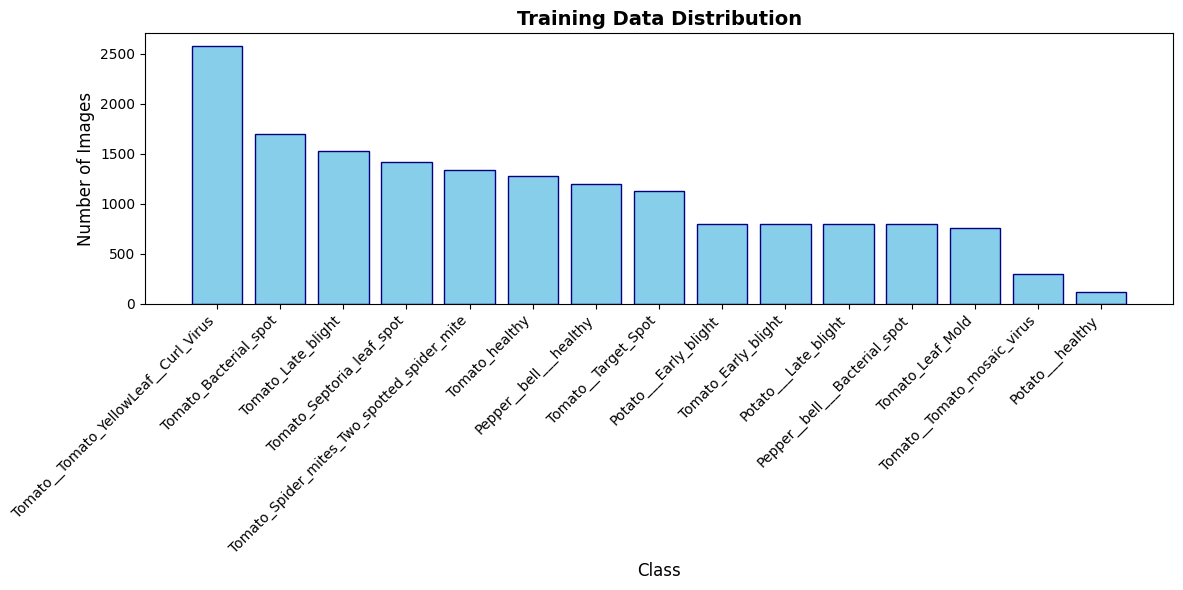


Total Images: 16535
Average per class: 1102
Min: 122, Max: 2574


In [26]:
# Cell 5: Data Visualization - Class Distribution
import matplotlib.pyplot as plt
import numpy as np # Ensure numpy is imported for np.mean

def plot_class_distribution(class_counts, title="Class Distribution"):
    """Visualize class distribution"""
    plt.figure(figsize=(12, 6))
    classes = list(class_counts.keys())
    counts = list(class_counts.values())

    plt.bar(classes, counts, color='skyblue', edgecolor='navy')
    plt.xlabel('Class', fontsize=12)
    plt.ylabel('Number of Images', fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    print(f"\nTotal Images: {sum(counts)}")
    print(f"Average per class: {np.mean(counts):.0f}")
    print(f"Min: {min(counts)}, Max: {max(counts)}")

# Regenerate train_counts and test_counts from the dataframes
# (The original explore_data function failed due to directory structure)
train_counts = train_df['label'].value_counts().to_dict()
test_counts = test_df['label'].value_counts().to_dict()

plot_class_distribution(train_counts, "Training Data Distribution")

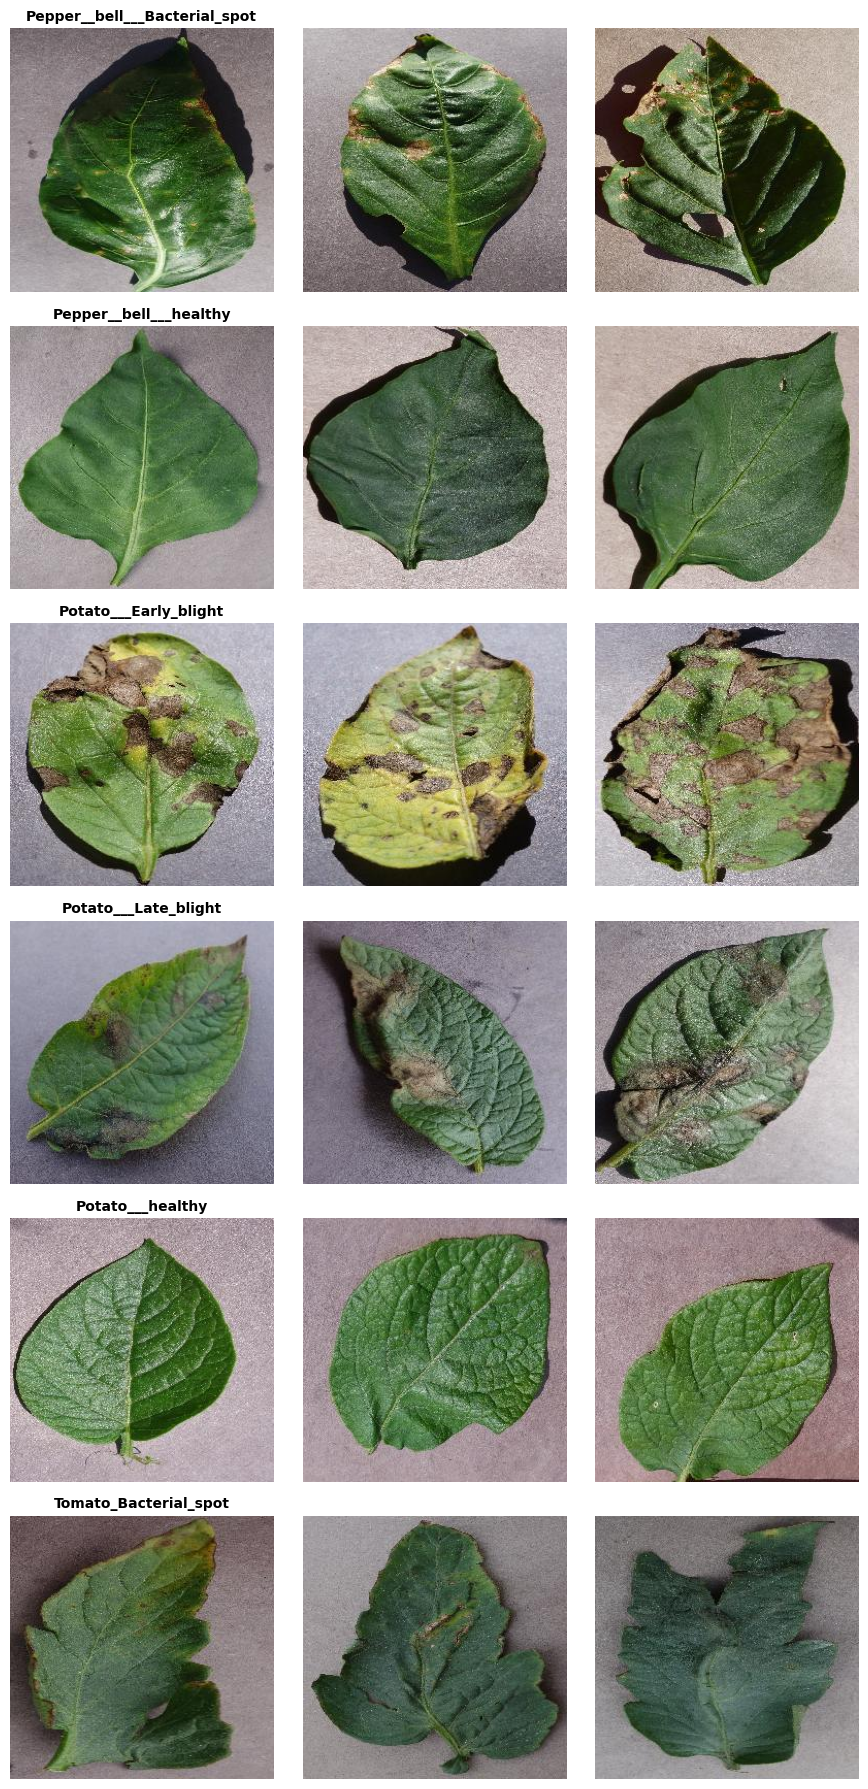

In [28]:
# Cell 6: Sample Images Visualization
import random
from PIL import Image # Pillow library for image handling

def display_sample_images_from_df(dataframe, classes, samples_per_class=3):
    """Display sample images from each class from a DataFrame"""
    n_classes = len(classes)
    fig, axes = plt.subplots(n_classes, samples_per_class,
                            figsize=(samples_per_class*3, n_classes*3))

    # Flatten axes if n_classes is 1, to handle single row plots correctly
    if n_classes == 1:
        axes = np.array([axes])

    for i, cls in enumerate(classes):
        # Filter dataframe for the current class
        class_df = dataframe[dataframe['label'] == cls]
        # Randomly sample image paths for the current class
        sample_filepaths = random.sample(list(class_df['filepath']), min(samples_per_class, len(class_df)))

        for j, img_path in enumerate(sample_filepaths):
            try:
                img = Image.open(img_path) # Use PIL for robust image loading
                ax = axes[i, j]
                ax.imshow(img)
                ax.axis('off')
                if j == 0:
                    ax.set_title(cls, fontsize=10, fontweight='bold')
            except Exception as e:
                print(f"Could not load image {img_path}: {e}")
                ax = axes[i, j]
                ax.text(0.5, 0.5, "Error", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
                ax.axis('off')

    plt.tight_layout()
    plt.show()

# Call the new function using the train_df
display_sample_images_from_df(train_df, config.CLASSES[:6])

In [30]:
# Cell 7: Data Preprocessing
# This cell's functionality has been replaced by the programmatic data split and
# ImageDataGenerator.flow_from_dataframe() in previous steps (e.g., cell 9352ed76).
# The 'create_data_generators' function here attempts to use 'flow_from_directory'
# which expects 'train' and 'test' subdirectories that do not exist in the current
# data structure.

# Commenting out the original code to avoid FileNotFoundError.
# def create_data_generators():
#     """Create train and validation data generators with augmentation"""

#     # Training data augmentation
#     train_datagen = ImageDataGenerator(
#         rescale=1./255,
#         rotation_range=20,
#         width_shift_range=0.2,
#         height_shift_range=0.2,
#         shear_range=0.2,
#         zoom_range=0.2,
#         horizontal_flip=True,
#         fill_mode='nearest',
#         validation_split=0.2
#     )

#     # Test data - only rescaling
#     test_datagen = ImageDataGenerator(rescale=1./255)

#     # Training generator
#     train_generator = train_datagen.flow_from_directory(
#         config.TRAIN_DIR,
#         target_size=config.IMAGE_SIZE,
#         batch_size=config.BATCH_SIZE,
#         class_mode='categorical',
#         subset='training',
#         shuffle=True
#     )

#     # Validation generator
#     validation_generator = train_datagen.flow_from_directory(
#         config.TRAIN_DIR,
#         target_size=config.IMAGE_SIZE,
#         batch_size=config.BATCH_SIZE,
#         class_mode='categorical',
#         subset='validation',
#         shuffle=False
#     )

#     # Test generator
#     test_generator = test_datagen.flow_from_directory(
#         config.TEST_DIR,
#         target_size=config.IMAGE_SIZE,
#         batch_size=config.BATCH_SIZE,
#         class_mode='categorical',
#         shuffle=False
#     )

#     return train_generator, validation_generator, test_generator

# # The following lines are commented out as the generators have already been created
# # in cell 9352ed76 using flow_from_dataframe.
# # train_gen, val_gen, test_gen = create_data_generators()

# # print(f"Training samples: {train_gen.samples}")
# # print(f"Validation samples: {val_gen.samples}")
# # print(f"Test samples: {test_gen.samples}")
# # print(f"Class indices: {train_gen.class_indices}")

print("Data generators were successfully created in a previous cell (9352ed76) using flow_from_dataframe.")
print("This cell's original content has been commented out to avoid conflicts with the adapted data loading approach.")

Data generators were successfully created in a previous cell (9352ed76) using flow_from_dataframe.
This cell's original content has been commented out to avoid conflicts with the adapted data loading approach.


In [32]:
# Cell 8: Model Architecture
from tensorflow.keras import models, layers # Import models and layers

def build_model(input_shape=(224, 224, 3), num_classes=6):
    """Build CNN model for plant disease classification"""

    model = models.Sequential([
        # Block 1
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Block 2
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Block 3
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Block 4
        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Dense layers
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

model = build_model(
    input_shape=(*config.IMAGE_SIZE, 3),
    num_classes=config.NUM_CLASSES
)

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,874,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 15)             │         3,855 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,400,399 (74.01 MB)

 Trainable params: 19,399,439 (74.00 MB)

 Non-trainable params: 960 (3.75 KB)

In [34]:
# Cell 9: Model Compilation
from tensorflow import keras
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=config.LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()]
)

In [36]:
# Cell 10: Callbacks
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7
    ),
    keras.callbacks.ModelCheckpoint(
        str(config.MODEL_DIR / 'best_model.h5'),
        monitor='val_accuracy',
        save_best_only=True
    )
]

In [ ]:
# Cell 11: Model Training
history = model.fit(
    train_generator,
    epochs=config.EPOCHS,
    validation_data=validation_generator,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/20
517/517 ━━━━━━━━━━━━━━━━━━━━ 2871s 6s/step - accuracy: 0.6991 - loss: 0.9663 - precision: 0.8101 - recall: 0.5977 - val_accuracy: 0.5445 - val_loss: 3.4004 - val_precision: 0.5966 - val_recall: 0.4683 - learning_rate: 0.0010
Epoch 2/20
517/517 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7321 - loss: 0.8619 - precision: 0.8215 - recall: 0.6465

517/517 ━━━━━━━━━━━━━━━━━━━━ 2993s 6s/step - accuracy: 0.7321 - loss: 0.8618 - precision: 0.8215 - recall: 0.6465 - val_accuracy: 0.8191 - val_loss: 0.5958 - val_precision: 0.8964 - val_recall: 0.6947 - learning_rate: 0.0010
Epoch 3/20
517/517 ━━━━━━━━━━━━━━━━━━━━ 2912s 6s/step - accuracy: 0.7634 - loss: 0.7794 - precision: 0.8383 - recall: 0.6876 - val_accuracy: 0.7755 - val_loss: 0.9600 - val_precision: 0.8316 - val_recall: 0.6930 - learning_rate: 0.0010
Epoch 4/20
517/517 ━━━━━━━━━━━━━━━━━━━━ 2947s 6s/step - accuracy: 0.7823 - loss: 0.7063 - precision: 0.8466 - recall: 0.7150 - val_accuracy: 0.7320 - val_loss: 1.5821 - val_precision: 0.7926 - val_recall: 0.6434 - learning_rate: 0.0010
Epoch 5/20
517/517 ━━━━━━━━━━━━━━━━━━━━ 2998s 6s/step - accuracy: 0.8079 - loss: 0.6317 - precision: 0.8714 - recall: 0.7516 - val_accuracy: 0.7666 - val_loss: 1.0578 - val_precision: 0.8226 - val_recall: 0.6911 - learning_rate: 0.0010
Epoch 6/20
517/517 ━━━━━━━━━━━━━━━━━━━━ 3009s 6s/step - accuracy: 0

In [4]:
# Cell 12: Training History Visualization
def plot_training_history(history):
    """Plot training and validation metrics"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Accuracy
    axes[0, 0].plot(history.history['accuracy'], label='Train')
    axes[0, 0].plot(history.history['val_accuracy'], label='Validation')
    axes[0, 0].set_title('Model Accuracy', fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Loss
    axes[0, 1].plot(history.history['loss'], label='Train')
    axes[0, 1].plot(history.history['val_loss'], label='Validation')
    axes[0, 1].set_title('Model Loss', fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Precision
    axes[1, 0].plot(history.history['precision'], label='Train')
    axes[1, 0].plot(history.history['val_precision'], label='Validation')
    axes[1, 0].set_title('Model Precision', fontweight='bold')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # Recall
    axes[1, 1].plot(history.history['recall'], label='Train')
    axes[1, 1].plot(history.history['val_recall'], label='Validation')
    axes[1, 1].set_title('Model Recall', fontweight='bold')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Recall')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_training_history(history)

NameError: name 'history' is not defined

In [6]:
# Cell 13: Model Evaluation
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test_gen)

print("\n=== Test Set Performance ===")
print(f"Loss: {test_loss:.4f}")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1-Score: {2 * (test_precision * test_recall) / (test_precision + test_recall):.4f}")

NameError: name 'model' is not defined

In [ ]:
# Cell 14: Confusion Matrix
# Get predictions
test_gen.reset()
predictions = model.predict(test_gen, verbose=1)
y_pred = np.argmax(predictions, axis=1)
y_true = test_gen.classes

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=config.CLASSES,
            yticklabels=config.CLASSES)
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

In [ ]:
# Cell 15: Classification Report
print("\n=== Classification Report ===")
print(classification_report(y_true, y_pred, target_names=config.CLASSES))

In [7]:
# Cell 16: Prediction Function
def predict_single_image(model, image_path, class_names):
    """Predict disease for a single image"""
    from tensorflow.keras.preprocessing import image

    # Load and preprocess image
    img = image.load_img(image_path, target_size=config.IMAGE_SIZE)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0

    # Predict
    predictions = model.predict(img_array, verbose=0)
    predicted_class_idx = np.argmax(predictions[0])
    confidence = predictions[0][predicted_class_idx]

    return {
        'class': class_names[predicted_class_idx],
        'confidence': float(confidence),
        'all_probabilities': {class_names[i]: float(predictions[0][i])
                             for i in range(len(class_names))}
    }

# Test prediction
test_image_path = list(config.TEST_DIR.glob("*/*.jpg"))[0]
result = predict_single_image(model, test_image_path, config.CLASSES)
print(f"\nPrediction Result:")
print(f"Class: {result['class']}")
print(f"Confidence: {result['confidence']:.2%}")

NameError: name 'config' is not defined

In [ ]:
# Cell 17: Visualize Predictions
def visualize_predictions(model, data_dir, class_names, num_samples=9):
    """Visualize model predictions on sample images"""
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    axes = axes.ravel()

    # Get random images
    all_images = list(Path(data_dir).glob("*/*.jpg"))[:num_samples]

    for idx, img_path in enumerate(all_images):
        img = plt.imread(img_path)

        # Get prediction
        result = predict_single_image(model, img_path, class_names)
        true_class = img_path.parent.name
        pred_class = result['class']
        confidence = result['confidence']

        # Plot
        axes[idx].imshow(img)
        color = 'green' if true_class == pred_class else 'red'
        axes[idx].set_title(f"True: {true_class}\nPred: {pred_class}\nConf: {confidence:.2%}",
                           color=color, fontsize=10)
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

visualize_predictions(model, config.TEST_DIR, config.CLASSES)

In [ ]:
# Cell 18: Save Model and Metadata
# Save model
model.save(config.MODEL_DIR / 'plant_disease_model.h5')
print(f"Model saved to: {config.MODEL_DIR / 'plant_disease_model.h5'}")

# Save metadata
metadata = {
    'model_version': '1.0.0',
    'created_at': datetime.now().isoformat(),
    'classes': config.CLASSES,
    'num_classes': config.NUM_CLASSES,
    'image_size': config.IMAGE_SIZE,
    'training_samples': train_gen.samples,
    'test_accuracy': float(test_accuracy),
    'test_precision': float(test_precision),
    'test_recall': float(test_recall),
    'architecture': 'Custom CNN',
    'framework': 'TensorFlow/Keras'
}

with open(config.MODEL_DIR / 'model_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"Metadata saved to: {config.MODEL_DIR / 'model_metadata.json'}")

In [ ]:
# Cell 19: Model Interpretability - Feature Maps
def visualize_feature_maps(model, img_path, layer_names=None):
    """Visualize CNN feature maps"""
    from tensorflow.keras.preprocessing import image

    # Load image
    img = image.load_img(img_path, target_size=config.IMAGE_SIZE)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0

    # Get conv layers
    if layer_names is None:
        layer_names = [layer.name for layer in model.layers
                      if 'conv' in layer.name][:3]

    # Create model for intermediate layers
    outputs = [model.get_layer(name).output for name in layer_names]
    feature_model = keras.Model(inputs=model.input, outputs=outputs)

    # Get feature maps
    feature_maps = feature_model.predict(img_array)

    # Plot
    for layer_name, feature_map in zip(layer_names, feature_maps):
        n_features = min(16, feature_map.shape[-1])
        fig, axes = plt.subplots(4, 4, figsize=(12, 12))

        for i, ax in enumerate(axes.flat):
            if i < n_features:
                ax.imshow(feature_map[0, :, :, i], cmap='viridis')
                ax.axis('off')

        plt.suptitle(f'Feature Maps: {layer_name}', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()

# Visualize for one image
sample_img = list(config.TEST_DIR.glob("*/*.jpg"))[0]
visualize_feature_maps(model, sample_img)

print("\n=== Notebook Complete ===")
print("Model trained, evaluated, and saved successfully!")
print(f"Next steps: Deploy using src/api.py and src/app.py")